In [64]:
##Import Libraries and Start Reading Data 
import pandas as pd 
import numpy as np 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle requests
import random # library for random number generation

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library



In [65]:
path = "C:/Users/alex.hodes/Desktop/Coursera_Capstone";


### Pull in walkability data for major cities

In [66]:
df_w = pd.read_csv(path + "/" + "walkability_cities.csv",encoding="utf-8")


In [67]:
#Replace all blank values with a 0 - mostly for cities that have no public transit
for i in df_w:
    for j in df_w[i]:
        if (j == "--"):
            df_w[i][j] = 0


C:\Users\alex.hodes\AppData\Local\Continuum\anaconda3\envs\data_science\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Credentials for Foursquare API 

In [68]:
CLIENT_ID = 'X0JSGTC0LWVHE4LTK4LHSKGD5T5V35ZINBSXVH2HOJEZ0XBO' # your Foursquare ID
CLIENT_SECRET = 'WSTOQVCCGG1LGBC12PJ4BCLJ1KYXNDOPS0KIATGV5MIGBHCA' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 400
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: X0JSGTC0LWVHE4LTK4LHSKGD5T5V35ZINBSXVH2HOJEZ0XBO
CLIENT_SECRET:WSTOQVCCGG1LGBC12PJ4BCLJ1KYXNDOPS0KIATGV5MIGBHCA


In [69]:
#Test Using Hometown as Address
address = 'Lenexa, KS'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
radius = 100000 #Max radius
print(latitude, longitude)
#Get request - search near city center
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
results = requests.get(url).json()
results #What does output look like?

C:\Users\alex.hodes\AppData\Local\Continuum\anaconda3\envs\data_science\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


38.9697458 -94.7845837


{'meta': {'code': 200, 'requestId': '5c0eb1bddd57971cfb820e90'},
 'response': {'venues': [{'id': '59a8acca8a6f173536192409',
    'name': 'Lenexa Public Market',
    'location': {'address': '8250 Penrose Ln',
     'crossStreet': 'W 87th St',
     'lat': 38.969845111265045,
     'lng': -94.783980117548,
     'labeledLatLngs': [{'label': 'display',
       'lat': 38.969845111265045,
       'lng': -94.783980117548}],
     'distance': 53,
     'postalCode': '66219',
     'cc': 'US',
     'city': 'Lenexa',
     'state': 'KS',
     'country': 'United States',
     'formattedAddress': ['8250 Penrose Ln (W 87th St)',
      'Lenexa, KS 66219',
      'United States']},
    'categories': [{'id': '50be8ee891d4fa8dcc7199a7',
      'name': 'Market',
      'pluralName': 'Markets',
      'shortName': 'Market',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/market_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1544466877',
    'hasPerk': False},
   {'id

In [70]:
#Function that prevents timing out to access longitude and lattitude of city by name 
from geopy.exc import GeocoderTimedOut

def do_geocode(address):
    try:
        return geolocator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)


## Heavy lifting - loop through the list of cities in walkability data.

In [71]:
#Set up lists
g_avg = []
w_avg = []
r_avg = []
#Loop through walkability data 
for index, row in df_w.iterrows():
    address = row[0] + "," + " " + row[1]
    location = do_geocode(address) #Convert city, state into longitude and latitude
    latitude = location.latitude
    longitude = location.longitude
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json() #Make request to Foursquare API
    radius = 100000

    dist = 0
    g_dist = 0; g_n=0; w_dist=0; w_n=0; r_dist=0; r_n=0; 
    #Loop through each response
    for each in results['response']['venues']:
        for i in each['categories']:
            #Find all grocery stores or markets
            if ("market" in i['name'].lower()) or ("grocery" in i['name'].lower()):
                g_dist += (each['location']['distance'])
                g_n += 1
            #Find all offices - reflective of jobs
            elif ("office" in i['name'].lower()):
                w_dist += (each['location']['distance'])
                w_n += 1
            #Find all restaurants, coffee, cafe for recreational data 
            elif ("restaurant" in i['name'].lower()) or ("cafe" in i['name'].lower()) or ("coffee" in i['name'].lower()) or ("bar" in i['name'].lower()):
                r_dist += (each['location']['distance'])
                r_n += 1
    #Average each distance - grocery venues, work venues, recreational venues
    if (g_n == 0):
        g_avg.append(0)
    else:
        g_avg.append(g_dist/g_n)

    if (w_n == 0):
        w_avg.append(0)
    else:
        w_avg.append(w_dist/w_n)
    if (r_n == 0):
        r_avg.append(0)
    else:
        r_avg.append(r_dist/r_n)
print(g_avg)

[96.0, 112.0, 17.0, 90.8, 89.0, 232.0, 0, 0, 0, 0, 389.0, 0, 0, 0, 113.0, 0, 23.0, 0, 192.0, 173.0, 269.0, 100.66666666666667, 38.0, 0, 0, 0, 0, 905.0, 54.0, 0, 0, 216.0, 136.0, 1179.3333333333333, 87.0, 488.0, 0, 2566.0, 0, 109.0, 1684.0, 0, 0, 0, 0, 404.0, 1845.6666666666667, 0, 0, 850.3333333333334, 0, 0, 0, 328.75, 0, 0, 0, 0, 305.0, 0, 4581.0, 0, 0, 0, 0, 1106.0, 0, 187.0, 55.0, 355.0, 0, 395.0, 296.0, 209.0, 282.0, 0, 412.0, 940.0, 0, 380.0, 230.0, 128.5, 161.33333333333334, 0, 0, 68.25, 0, 1980.0, 0, 473.6666666666667, 0, 482.0, 0, 0, 883.0, 314.6666666666667, 0, 0, 0, 0, 0, 319.0, 76.33333333333333, 0, 430.0, 0, 300.0, 255.0]


### Pull in calculated average distances with walkability and bike scores

In [72]:
#Make a master Dataframe 
master_data = pd.DataFrame()
master_data['city'] = df_w['City']
master_data['state'] = df_w['State']
master_data['groceries'] = g_avg
master_data['work'] = w_avg
master_data['rec'] = r_avg

#Make sure there aren't any blank values
df_w['Walk Score'] = df_w['Walk Score'].replace("--",0,regex=True).astype(float)
df_w['Bike Score'] = df_w['Bike Score'].replace("--",0,regex=True).astype(float)

#If the average values are 0 then replace with the max distance in that column  
master_data['rec'] = master_data['rec'].replace(0,max(master_data['rec']))
master_data['groceries'] = master_data['groceries'].replace(0,max(master_data['groceries']))
master_data['work'] = master_data['work'].replace(0,max(master_data['work']))

#Make sure all values are float and not strings 
master_data['walk_score'] = df_w['Walk Score'].astype(float)
master_data['bike_score'] = df_w['Bike Score'].astype(float)
master_data['population'] = df_w['Population']
master_data['population'] = master_data['population'].replace(',','',regex=True).astype(float)

#Calculate a metric for whether a car is necessary - the higher the no_car_score is the more easily
#it is to live in the city without a car. If the city is walkable and bikeable then you may not need
#a car. 
master_data['no_car_score'] = (master_data['walk_score'] + master_data['bike_score'])/2

#Shuffle dataframe
master_data = master_data.sample(frac=1).reset_index(drop=True)


### Visualize where cutoff of no-car and car is? - Most cities in America you need a car

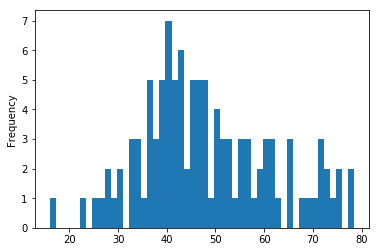

In [73]:
#We should change no_car_score into a boolean - do you need a car or not?
import matplotlib.pyplot as plt
master_data['no_car_score'].plot.hist(bins=50)

In [74]:
#Use no_car_score as a split to no cars and cars. There is a clear 'upper tier' of no_car scores
#that cut off at 65
master_data['no_car'] = master_data['no_car_score'] >= 65
master_data['no_car'] = master_data['no_car'].astype(float)

In [75]:
#If a column is = to 0 this means there are no values for that column so replace by maximum.
#smaller values are representative of 
master_data['rec'] = master_data['rec'].replace(0,max(master_data['rec']))
master_data['groceries'] = master_data['groceries'].replace(0,max(master_data['groceries']))
master_data['work'] = master_data['work'].replace(0,max(master_data['work']))


### Set features as average distance for recreational venues, grocery venues, and work/offices

In [76]:
#Feature = master_data[['rec','groceries','work','population']]
Feature = master_data[['rec','groceries','work']]

X = Feature
y = master_data['no_car']

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

X_tr, X_te, y_tr, y_te = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_tr.shape,  y_tr.shape)
print ('Test set:', X_te.shape,  y_te.shape)


Train set: (86, 3) (86,)
Test set: (22, 3) (22,)


## K-nearest neighbors

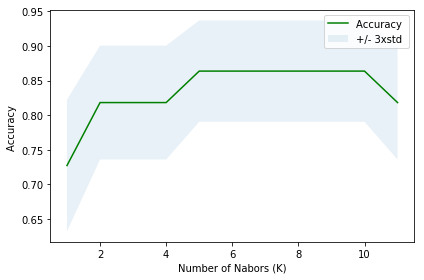

The best accuracy was 0.8636363636363636 with k= 5


In [78]:
Ks = 12
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
#Loop through all K values
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_tr,y_tr)
    yhat=neigh.predict(X_te)
    mean_acc[n-1] = metrics.accuracy_score(y_te, yhat)
    std_acc[n-1]=np.std(yhat==y_te)/np.sqrt(yhat.shape[0])

mean_acc
#Visualize Accuracy dependent on K 
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [79]:
neigh = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1).fit(X_tr,y_tr)
yhat=neigh.predict(X_te)
print("KNN Accuracy: ")
print("with k = ",mean_acc.argmax()+1)
print("f1 score: ", f1_score(y_te, yhat, average='weighted')) 
print("jaccard score: ", jaccard_similarity_score(y_te, yhat))

KNN Accuracy: 
with k =  5
f1 score:  0.827972027972028
jaccard score:  0.8636363636363636


## Decision Tree 

In [80]:
from sklearn.tree import DecisionTreeClassifier

Tree = DecisionTreeClassifier(criterion="entropy",max_depth = 6)
Tree.fit(X_tr,y_tr)
predTree = Tree.predict(X_te)
print("DecisionTrees's Accuracy: ")
print("f1 score: ", f1_score(y_te, predTree, average='weighted')) 
print("jaccard score: ", jaccard_similarity_score(y_te, predTree))

DecisionTrees's Accuracy: 
f1 score:  0.6889952153110048
jaccard score:  0.7272727272727273


## Support Vector Machine 

In [81]:
from sklearn import svm


clf = svm.SVC(kernel='rbf')
clf.fit(X_tr, y_tr) 
yhat = clf.predict(X_te)
print("f1 score: ", f1_score(y_te, yhat, average='weighted')) 
print("jaccard score: ", jaccard_similarity_score(y_te, yhat))

f1 score:  0.7363636363636363
jaccard score:  0.8181818181818182


C:\Users\alex.hodes\AppData\Local\Continuum\anaconda3\envs\data_science\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alex.hodes\AppData\Local\Continuum\anaconda3\envs\data_science\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
clf = svm.SVC(kernel='sigmoid')
clf.fit(X_tr, y_tr) 
yhat = clf.predict(X_te)
print("f1 score: ", f1_score(y_te, yhat, average='weighted')) 
print("jaccard score: ", jaccard_similarity_score(y_te, yhat))

f1 score:  0.7363636363636363
jaccard score:  0.8181818181818182


C:\Users\alex.hodes\AppData\Local\Continuum\anaconda3\envs\data_science\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alex.hodes\AppData\Local\Continuum\anaconda3\envs\data_science\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Logistic Regression


In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_tr,y_tr)
yhat = LR.predict(X_te)
print("Logistic regression accuracy results: ")
print("f1 score: ", f1_score(y_te, yhat, average='weighted')) 
print("jaccard score: ", jaccard_similarity_score(y_te, yhat))
yhat_prob = LR.predict_proba(X_te)
print("log loss: ", log_loss(y_te, yhat_prob))

Logistic regression accuracy results: 
f1 score:  0.7363636363636363
jaccard score:  0.8181818181818182
log loss:  0.5004924356639471


C:\Users\alex.hodes\AppData\Local\Continuum\anaconda3\envs\data_science\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### K-nearest neighbors performed best at classifying car or no car cities  with an accuracy of 83%

In [84]:
#Suburb names that we are comparing
df_sub = pd.DataFrame()
df_sub['City'] = ['Carmel, IN','Chesterbrook, PA','Clarendon Hills, IL','Richmond Heights, MO', \
          'Buffalo Grove, IL', 'Clayton, MO','Birmingham, MI','Dublin, OH','Olathe, KS',\
          'Leawood, KS', 'Overland Park, KS', 'Lenexa, KS','Naperville, IL','Cambridge, MA','Arlington, VA']

In [85]:
#Set up lists
g_avg = []
w_avg = []
r_avg = []
r_cnt = []
#Loop through walkability data 
for index, row in df_sub.iterrows():
    address = row[0]
    location = do_geocode(address) #Convert city, state into longitude and latitude
    latitude = location.latitude
    longitude = location.longitude
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json() #Make request to Foursquare API
    radius = 100000

    dist = 0
    g_dist = 0; g_n=0; w_dist=0; w_n=0; r_dist=0; r_n=0; 
    #Loop through each response
    for each in results['response']['venues']:
        for i in each['categories']:
            #Find all grocery stores or markets
            if ("market" in i['name'].lower()) or ("grocery" in i['name'].lower()):
                g_dist += (each['location']['distance'])
                g_n += 1
            #Find all offices - reflective of jobs
            elif ("office" in i['name'].lower()):
                w_dist += (each['location']['distance'])
                w_n += 1
            #Find all restaurants, coffee, cafe for recreational data 
            elif ("restaurant" in i['name'].lower()) or ("cafe" in i['name'].lower()) or ("coffee" in i['name'].lower()) or ("bar" in i['name'].lower()):
                r_dist += (each['location']['distance'])
                r_n += 1
    #Average each distance - grocery venues, work venues, recreational venues
    if (g_n == 0):
        g_avg.append(0)
    else:
        g_avg.append(g_dist/g_n)

    if (w_n == 0):
        w_avg.append(0)
    else:
        w_avg.append(w_dist/w_n)
    if (r_n == 0):
        r_avg.append(0)
        r_cnt.append(r_n)
    else:
        r_avg.append(r_dist/r_n)
        r_cnt.append(r_n)




In [86]:
#Make a Dataframe for experimental suburbs - 
exp_data = pd.DataFrame()
exp_data['city'] = df_sub['City']
exp_data['groceries'] = g_avg
exp_data['work'] = w_avg
exp_data['rec'] = r_avg
exp_data['rec_count']= r_cnt

#If the average values are 0 then replace with the max distance in that column  
exp_data['rec'] = exp_data['rec'].replace(0,max(master_data['rec']))
exp_data['groceries'] = exp_data['groceries'].replace(0,max(master_data['groceries']))
exp_data['work'] = exp_data['work'].replace(0,max(master_data['work']))


In [87]:
Feature = exp_data[['rec','groceries','work']]
X_new = Feature
#print("DecisionTrees's Accuracy: ")
#print("f1 score: ", f1_score(y_te, predTree, average='weighted')) 
#print("jaccard score: ", jaccard_similarity_score(y_te, predTree))
y_new=neigh.predict(X_new)
y_new

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.])

In [88]:
exp_data['no_car'] = y_new.tolist()
exp_data

,city,groceries,work,rec,rec_count,no_car
0,"Carmel, IN",4581.000000,421.000000,465.894737,19,0.0
1,"Chesterbrook, PA",4581.000000,652.764706,656.857143,14,0.0
2,"Clarendon Hills, IL",1071.000000,398.428571,270.933333,15,0.0
3,"Richmond Heights, MO",4581.000000,274.827586,382.000000,6,0.0
4,"Buffalo Grove, IL",409.000000,501.111111,468.666667,12,0.0
5,"Clayton, MO",4581.000000,593.833333,700.000000,14,0.0
6,"Birmingham, MI",90.000000,3334.166667,58.600000,25,0.0
7,"Dublin, OH",4581.000000,219.571429,126.190476,21,0.0
8,"Olathe, KS",208.000000,244.909091,349.666667,9,0.0
9,"Leawood, KS",4581.000000,791.619048,915.750000,4,0.0


In [90]:
exp_data[exp_data['no_car'] == 1].sort_values(by=['rec_count'],ascending=False)

,city,groceries,work,rec,rec_count,no_car
12,"Naperville, IL",29.000000,125.250000,113.809524,42,1.0
14,"Arlington, VA",76.333333,134.444444,141.812500,16,1.0


### The only suburbs on the list that a citizen does not need a car, according to the model are Naperville, IL and Arlington, VA. Naperville has more recreational venues near the town center and is chosen as the town to explore further.

In [112]:

location = do_geocode("Naperville, IL") #Convert city, state into longitude and latitude
latitude = location.latitude
longitude = location.longitude
# define URL
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

# send GET request and get trending venues
results = requests.get(url).json()


### Let's take a look at the map of the city and venues nearby

In [114]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [115]:
import folium # plotting library

items = results['response']['groups'][0]['items']
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head(10)

venues_map = folium.Map(location=[latitude, longitude], zoom_start=10) # generate map centred around Ecco



# add popular spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.Marker(
        [lat, lng],
        popup=label,
        ).add_to(venues_map)

# display map
venues_map